In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
%matplotlib inline

In [6]:
stats = pd.read_json('article-stats.json').query('n_epoch == 10 and ensemble_size in (1, 3, 6, 12)')

In [7]:
tl = stats.metrics.map(lambda e: e['valid_auc'])
tl_es = [(i, e, es) for l, es in zip(tl.tolist(), stats.ensemble_size) for i, e in enumerate(l)]
tl_df = pd.DataFrame(tl_es, columns=['epoch', 'loss', 'ens_size'])

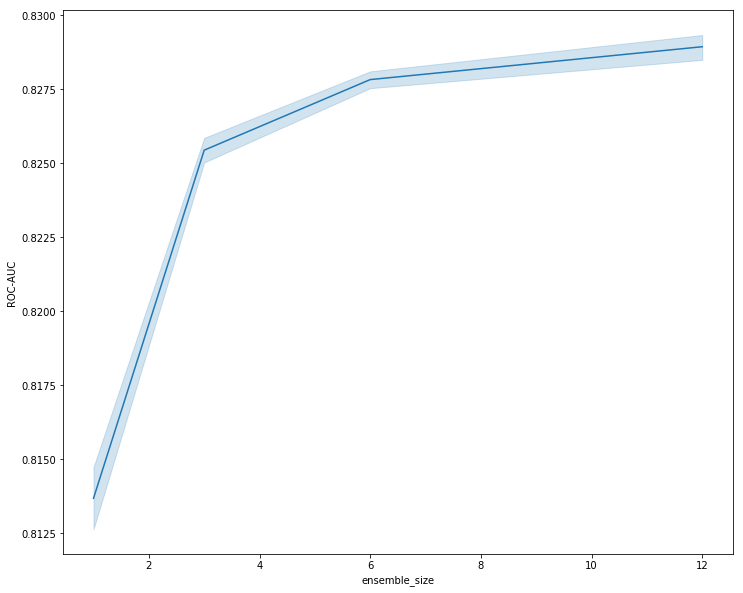

In [8]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.lineplot(x="ensemble_size", y="ROC-AUC", data=stats, legend="full")

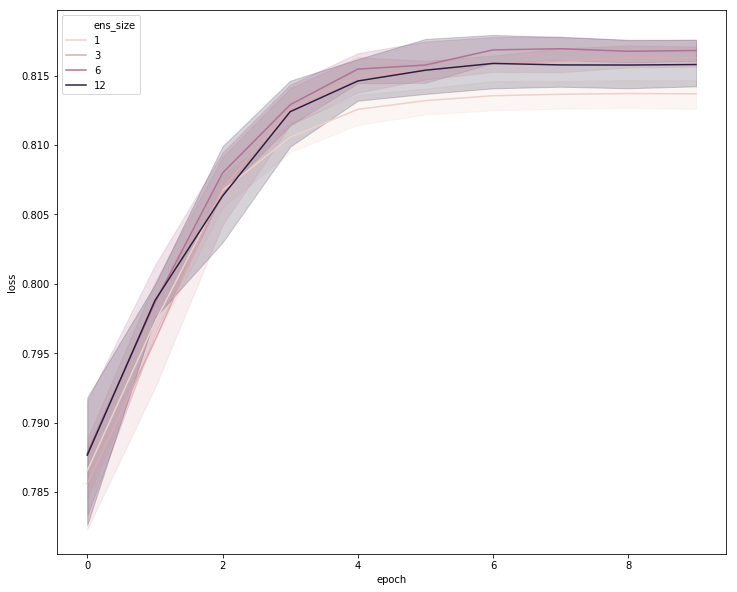

In [9]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.lineplot(x="epoch", y="loss", hue="ens_size", data=tl_df, legend="full")

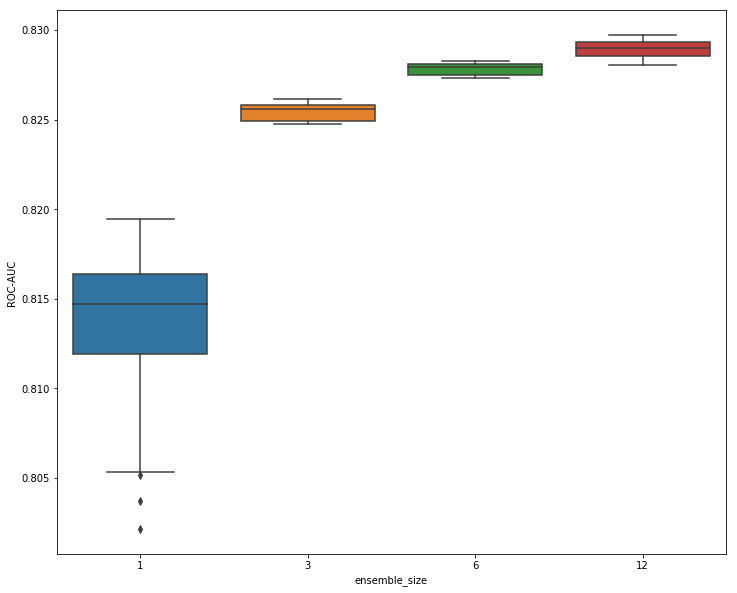

In [10]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.boxplot(x="ensemble_size", y="ROC-AUC", data=stats)